In [1]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import mapclassify
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Machine learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_regression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the GeoParquet file without one-hot sampling
df = pd.read_parquet('df_imputed')

gdf = df

In [3]:
gdf

,year,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent_data,pf_ss,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_expression_cld,pf_identity_divorce,pf_identity_fgm,...,ef_regulation_labor_conscription,ef_regulation_labor,ef_regulation_business_adm,ef_regulation_business_start,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_score,ef_government_tax,pf_expression_bti,pf_rol_civil
0,2020.0,Eastern Europe,10.0,0.0,9.249726,0.0,0.0,3.333333,7.5,10.0,...,10.0,6.717929,5.651538,9.742477,5.621940,7.175250,0,0,0,0
1,2020.0,Middle East & North Africa,10.0,25.0,8.840074,0.0,8.0,3.333333,0.0,10.0,...,3.0,5.645397,4.215154,9.305002,8.771111,7.029528,0,0,0,0
2,2020.0,Sub-Saharan Africa,10.0,25.0,8.473782,0.0,0.0,3.333333,5.0,10.0,...,0.0,5.338186,2.937894,8.730805,7.916416,6.782923,0,0,0,0
3,2020.0,Latin America & the Caribbean,5.0,0.0,8.504898,0.0,0.0,6.666667,10.0,10.0,...,10.0,5.119549,2.714233,9.579288,5.726521,6.508295,0,0,0,0
4,2020.0,Caucasus & Central Asia,10.0,0.0,9.395818,0.0,0.0,6.666667,7.5,10.0,...,0.0,6.461113,5.170406,9.863530,9.302574,7.040738,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000.0,Latin America & the Caribbean,10.0,0.0,4.794431,0.0,0.0,6.666667,2.5,10.0,...,0.0,3.354982,6.417950,6.268547,4.529453,0.315142,0,0,0,1
3482,2000.0,South Asia,10.0,0.0,9.219733,0.0,16.0,0.000000,7.5,10.0,...,0.0,5.411519,3.000000,7.885638,2.755084,0.000000,0,1,0,1
3483,2000.0,Middle East & North Africa,5.0,0.0,7.722447,0.0,0.0,3.333333,0.0,10.0,...,0.0,5.502918,2.620223,8.735527,8.917008,7.220087,1,1,0,1
3484,2000.0,Sub-Saharan Africa,10.0,0.0,8.169151,0.0,2.0,6.666667,7.5,10.0,...,10.0,6.172222,3.166667,8.537578,1.776236,8.520369,0,0,0,1


## Feature scaling

Feature scaling is a method used to standardize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

Note: Before doing feature scaling, make sure to split your data into train and test sets, to avoid data leakage. Data leakage can happen when information from outside your training dataset is used to create the model. This can cause the model to overestimate its accuracy.

First, let's do a **Train-Test Split** with respect to the temporal data nature:

In [4]:
# Sort the data by year
gdf = gdf.sort_values('year')

# Drop the region used for visualization (this is a pure modelling approach)
gdf = gdf.drop(columns=['region'])

gdf.head()

,year,pf_ss_disappearances_disap,pf_ss_disappearances_violent_data,pf_ss,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_expression_cld,pf_identity_divorce,pf_identity_fgm,ef_government_soa,...,ef_regulation_labor_conscription,ef_regulation_labor,ef_regulation_business_adm,ef_regulation_business_start,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_score,ef_government_tax,pf_expression_bti,pf_rol_civil
3485,2000.0,5.0,0.0,6.416393,0.0,0.0,3.333333,7.5,9.5,4.6550,...,10.0,4.064863,5.101020,3.725702,0.000000,7.578785,0,0,0,1
3378,2000.0,10.0,0.0,9.524490,0.0,0.0,6.666667,2.5,8.0,7.3250,...,10.0,6.444444,3.500000,6.491809,7.321867,6.592365,0,0,0,1
3377,2000.0,10.0,0.0,9.750811,0.0,0.0,10.000000,10.0,9.5,9.3275,...,3.0,2.979282,8.184970,8.337289,8.766560,7.802972,0,0,1,1
3376,2000.0,5.0,0.0,7.750007,1.0,0.0,3.333333,7.5,10.0,6.1125,...,1.0,7.320154,2.666667,8.876997,7.738589,4.978222,0,1,0,1
3375,2000.0,10.0,0.0,6.741708,0.0,0.0,3.333333,0.0,3.0,6.5825,...,10.0,8.097741,5.619699,6.970583,8.237995,5.785293,1,1,1,1


In [5]:
# Create the X and y variables
X = gdf.drop(['ef_score', 'ef_government_tax', 'pf_expression_bti', 'pf_rol_civil'], axis=1)  # Features
y = gdf[['ef_score', 'ef_government_tax', 'pf_expression_bti', 'pf_rol_civil']]  # Targets

# Calculate the index at which to split the data (60/40 split)
split_index = int(len(X) * 0.6)

# Perform a chronological train-test split
X_temp_train, X_temp_test = X[:split_index], X[split_index:]
y_temp_train, y_temp_test = y[:split_index], y[split_index:]

### Scaling on temporal training and test data

In [6]:
# Separate 'year' from features
year_train = X_temp_train.pop('year')
year_test = X_temp_test.pop('year')

# Initialize a new scaling object for normalizing input variables
scaler = StandardScaler()

# Select only numeric features
X_temp_train_numeric = X_temp_train.select_dtypes(include=np.number)
X_temp_test_numeric = X_temp_test.select_dtypes(include=np.number)

# Fit the scaler object to the training data
scaler.fit(X_temp_train_numeric)

# Apply the scaler object to the training and test sets
X_temp_train_scaled = scaler.transform(X_temp_train_numeric)
X_temp_test_scaled = scaler.transform(X_temp_test_numeric)

# Replace the original numeric columns with the scaled ones
X_temp_train[X_temp_train_numeric.columns] = X_temp_train_scaled
X_temp_test[X_temp_test_numeric.columns] = X_temp_test_scaled

# Add 'year' back to features
X_temp_train['year'] = year_train
X_temp_test['year'] = year_test

### Scaling on stratified training and test data

In [7]:
# Perform stratified train-test split on the original unsorted X and y datasets
X_strat_train, X_strat_test, y_strat_train, y_strat_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=2)

# Separate 'year' from features
year_strat_train = X_strat_train.pop('year')
year_strat_test = X_strat_test.pop('year')

# Select only numeric features
X_strat_train_numeric = X_strat_train.select_dtypes(include=np.number)
X_strat_test_numeric = X_strat_test.select_dtypes(include=np.number)

# Fit the scaler object to the training data
scaler.fit(X_strat_train_numeric)

# Apply the scaler object to the training and test sets
X_strat_train_scaled = scaler.transform(X_strat_train_numeric)
X_strat_test_scaled = scaler.transform(X_strat_test_numeric)

# Replace the original numeric columns with the scaled ones
X_strat_train[X_strat_train_numeric.columns] = X_strat_train_scaled
X_strat_test[X_strat_test_numeric.columns] = X_strat_test_scaled

# Add 'year' back to features
X_strat_train['year'] = year_strat_train
X_strat_test['year'] = year_strat_test

In [8]:
# Class balance for temporal sampling
ef_score_temporal_balance = y_temp_train['ef_score'].value_counts(normalize=True)
print("Class balance for temporal sampling (ef_score):\n", ef_score_temporal_balance)

# Class balance for stratified sampling
ef_score_stratified_balance = y_strat_train['ef_score'].value_counts(normalize=True)
print("Class balance for stratified sampling (ef_score):\n", ef_score_stratified_balance)

Class balance for temporal sampling (ef_score):
 0    0.832616
1    0.167384
Name: ef_score, dtype: float64
Class balance for stratified sampling (ef_score):
 0    0.890483
1    0.109517
Name: ef_score, dtype: float64


In [9]:
# Class balance for temporal sampling
ef_score_temporal_balance = y_temp_test['ef_score'].value_counts(normalize=True)
print("Class balance for temporal sampling (ef_score):\n", ef_score_temporal_balance)

# Class balance for stratified sampling
ef_score_stratified_balance = y_strat_test['ef_score'].value_counts(normalize=True)
print("Class balance for stratified sampling (ef_score):\n", ef_score_stratified_balance)

Class balance for temporal sampling (ef_score):
 0    0.977061
1    0.022939
Name: ef_score, dtype: float64
Class balance for stratified sampling (ef_score):
 0    0.890323
1    0.109677
Name: ef_score, dtype: float64


## Feature selection optimization (Random Forest with genetic mutation)

## Modelling: Statistical

### Logistic Regression (model baseline)

In [10]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

def train_and_evaluate_models(selected_features_dict, X_train, X_test, y_train, y_test):
    
    # Initialize a dictionary to store models
    models = {}

    for target in selected_features_dict.keys():
        print(f"\nTraining model for {target}")

        # Get the best features for the target
        best_features = list(selected_features_dict[target].keys())

        # Subset X_train and X_test to only include the best features
        X_train_best = X_train[best_features]
        X_test_best = X_test[best_features]

        # Fit the model
        clf = LogisticRegression(random_state=0).fit(X_train_best, y_train[target])

        # Store the model
        models[target] = clf

        # Make predictions and evaluate
        y_pred = clf.predict(X_test_best)
        print(classification_report(y_test[target], y_pred))

    return models


In [11]:
models_temporal = train_and_evaluate_models(, X_temp_train, X_temp_test, y_temp_train, y_temp_test)

SyntaxError: invalid syntax (850873521.py, line 1)

In [ ]:
models_stratified = train_and_evaluate_models(, X_strat_train, X_strat_test, y_strat_train, y_strat_test)


Training model for ef_score
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1242
           1       0.33      0.01      0.03       153

    accuracy                           0.89      1395
   macro avg       0.61      0.50      0.48      1395
weighted avg       0.83      0.89      0.84      1395


Training model for ef_government_tax
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1168
           1       0.72      0.26      0.39       227

    accuracy                           0.86      1395
   macro avg       0.80      0.62      0.66      1395
weighted avg       0.85      0.86      0.84      1395


Training model for pf_expression_bti
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       998
           1       0.70      0.45      0.55       397

    accuracy                           0.79      1395
   macro avg       0.75

### Random Forest & XGBoost with GridSearch optimization

In [12]:
import time
from sklearn.metrics import roc_auc_score, matthews_corrcoef, balanced_accuracy_score
from sklearn.preprocessing import LabelBinarizer

def classification_report_to_dict(target, y_true, y_pred, y_pred_proba, feature_importances, cv_method, feature_names, duration):
    
    # Note: You might need to adapt this to your specific context
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    y_pred_bin = lb.transform(y_pred)

    scores = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    macro_f1 = scores['macro avg']['f1-score']
    roc_auc = roc_auc_score(y_true_bin, y_pred_proba[:, 1])
    matthews_corr = matthews_corrcoef(y_true, y_pred)
    
    # Indices of features sorted by importance
    top_features = np.argsort(feature_importances)[::-1]  
    reports = []
    
    for class_label, metrics in scores.items():
        if class_label.isdigit():  # only process class labels, skip 'accuracy', 'macro avg' and 'weighted avg'
            report_dict = {
                'target': target,
                'class_label': class_label,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1-score'],
                'accuracy': accuracy,
                'balanced_accuracy': balanced_accuracy,
                'macro_f1': macro_f1,
                'roc_auc': roc_auc,
                'matthews_corr': matthews_corr,
                'cv_method': cv_method,
                'top1_feature': feature_names[top_features[0]] if len(top_features) > 0 else None,
                'top2_feature': feature_names[top_features[1]] if len(top_features) > 1 else None,
                'top3_feature': feature_names[top_features[2]] if len(top_features) > 2 else None,
                'time': duration
            }
            reports.append(report_dict)
    return reports

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import plotly.graph_objects as go
from sklearn.metrics import classification_report

# Initialize dictionaries to store the best models
best_models_rf = {}
best_models_xgb = {}
best_models_nn = {}
best_models_lgbm = {}

rf_params = {
    'n_estimators': [5, 10, 20],
    'max_depth': [2, 3, 4],
    'min_samples_split': [5, 10, 15]
}

xgb_params = {
    'n_estimators': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'gamma': [0, 0.1, 0.2]
}

nn_params = {
    'hidden_layer_sizes': [50, 100, 150],  # Single hidden layer
    'learning_rate_init': [0.01, 0.001, 0.0001],
    'max_iter': [200, 300, 400],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 penalty (regularization term) parameter
}

lgbm_params = {
    'n_estimators': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
}

def model(X_train, X_test, y_train, y_test, selected_features_dict, cv, cv_method_name, results_df=None):
    results = []

    for target in y_train.columns:
        print(f"\nPerforming grid search for models for {target}")

        # Use all features in the training set
        X_train_best = X_train
        X_test_best = X_test

        # Random Forest model
        print("Performing grid search for Random Forest Model")
        start_time_rf = time.time()
        rf_grid = GridSearchCV(RandomForestClassifier(random_state=2), rf_params, cv=cv)
        rf_grid.fit(X_train_best, y_train[target])
        duration_rf = time.time() - start_time_rf
        best_models_rf[target] = rf_grid.best_estimator_
        y_pred_rf = best_models_rf[target].predict(X_test_best)
        y_pred_proba_rf = best_models_rf[target].predict_proba(X_test_best)
        
        print(f"\nClassification report for Random Forest model, {target}")
        print(classification_report(y_test[target], y_pred_rf))

        # Save metrics and feature importance
        results_rf = classification_report_to_dict(target, y_test[target], y_pred_rf, y_pred_proba_rf, best_models_rf[target].feature_importances_, cv_method_name, X_train_best.columns, duration_rf)
        for result in results_rf:
            result['model'] = 'RandomForest'
            results.append(result)

        # XGBoost model
        print("Performing grid search for XGBoost Model")
        start_time_xgb = time.time()
        xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), xgb_params, cv=cv)
        xgb_grid.fit(X_train_best, y_train[target])
        duration_xgb = time.time() - start_time_xgb
        best_models_xgb[target] = xgb_grid.best_estimator_
        y_pred_xgb = best_models_xgb[target].predict(X_test_best)
        y_pred_proba_xgb = best_models_xgb[target].predict_proba(X_test_best)

        print(f"\nClassification report for XGBoost model, {target}")
        print(classification_report(y_test[target], y_pred_xgb))

        # Save metrics and feature importance
        results_xgb = classification_report_to_dict(target, y_test[target], y_pred_xgb, y_pred_proba_xgb, best_models_xgb[target].feature_importances_, cv_method_name, X_train_best.columns, duration_xgb)
        for result in results_xgb:
            result['model'] = 'XGBoost'
            results.append(result)

        # Neural Network model
        print("Performing grid search for Neural Network Model")
        start_time_nn = time.time()
        nn_grid = GridSearchCV(MLPClassifier(random_state=0), nn_params, cv=cv)
        nn_grid.fit(X_train_best, y_train[target])
        duration_nn = time.time() - start_time_nn
        best_models_nn[target] = nn_grid.best_estimator_
        y_pred_nn = best_models_nn[target].predict(X_test_best)
        y_pred_proba_nn = best_models_nn[target].predict_proba(X_test_best)
        feature_importances_nn = np.mean(np.abs(best_models_nn[target].coefs_[0]), axis=1)
        top_features_nn = np.argsort(feature_importances_nn)[::-1]  # Indices
        
        print(f"\nClassification report for Neural Network model, {target}")
        print(classification_report(y_test[target], y_pred_nn))

        # Save metrics and approximate feature importance
        results_nn = classification_report_to_dict(target, y_test[target], y_pred_nn, y_pred_proba_nn, top_features_nn, cv_method_name, X_train_best.columns, duration_nn)
        for result in results_nn:
            result['model'] = 'NeuralNetwork'
            results.append(result)
            
        # LightGBM model
        print("Performing grid search for LightGBM Model")
        start_time_lgbm = time.time()
        lgbm_grid = GridSearchCV(LGBMClassifier(random_state=2), lgbm_params, cv=cv)
        lgbm_grid.fit(X_train_best, y_train[target])
        duration_lgbm = time.time() - start_time_lgbm
        best_models_lgbm[target] = lgbm_grid.best_estimator_
        y_pred_lgbm = best_models_lgbm[target].predict(X_test_best)
        y_pred_proba_lgbm = best_models_lgbm[target].predict_proba(X_test_best)

        print(f"\nClassification report for LightGBM model, {target}")
        print(classification_report(y_test[target], y_pred_lgbm))

        # Save metrics and feature importance
        results_lgbm = classification_report_to_dict(target, y_test[target], y_pred_lgbm, y_pred_proba_lgbm, best_models_lgbm[target].feature_importances_, cv_method_name, X_train_best.columns, duration_lgbm)
        for result in results_lgbm:
            result['model'] = 'LightGBM'
            results.append(result)

    # If results_df was provided, append new results to it; otherwise create a new DataFrame
    if results_df is not None:
        results_df = pd.concat([results_df, pd.DataFrame(results)], ignore_index=True)
    else:
        results_df = pd.DataFrame(results)

    return results_df, best_models_rf, best_models_xgb, best_models_nn, best_models_lgbm

In [14]:
# Create a dictionary of all original features for each target
all_features_dict = {target: list(X_temp_train.columns) for target in y_temp_train.columns}

# Pass this dictionary to the model function
tscv = TimeSeriesSplit(n_splits=5)
results_df, best_models_rf_temporal, best_models_xgb_temporal, best_models_nn_temporal, best_models_lgbm_temporal = model(X_temp_train, X_temp_test, y_temp_train, y_temp_test, all_features_dict, cv=tscv, cv_method_name="TimeSeriesSplit")

all_features_dict = {target: list(X_strat_train.columns) for target in y_strat_train.columns}

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
results_df, best_models_rf_stratified, best_models_xgb_stratified, best_models_nn_stratified, best_models_lgbm_stratified = model(X_strat_train, X_strat_test, y_strat_train, y_strat_test, all_features_dict, cv=skf, cv_method_name="StratifiedSplit", results_df=results_df)


Performing grid search for models for ef_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, ef_score
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1363
           1       0.61      0.69      0.65        32

    accuracy                           0.98      1395
   macro avg       0.80      0.84      0.82      1395
weighted avg       0.98      0.98      0.98      1395

Performing grid search for XGBoost Model

Classification report for XGBoost model, ef_score
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1363
           1       0.39      1.00      0.56        32

    accuracy                           0.96      1395
   macro avg       0.69      0.98      0.77      1395
weighted avg       0.99      0.96      0.97      1395

Performing grid search for Neural Network Model

Classification report for Neural Network model, ef_sc

In [15]:
results_df

,target,class_label,precision,recall,f1_score,accuracy,balanced_accuracy,macro_f1,roc_auc,matthews_corr,cv_method,top1_feature,top2_feature,top3_feature,time,model
0,ef_score,0,0.992642,0.989729,0.991183,0.982796,0.838614,0.819121,0.990187,0.639436,TimeSeriesSplit,ef_government,ef_government_soa,pf_identity_fgm,2.536614,RandomForest
1,ef_score,1,0.611111,0.687500,0.647059,0.982796,0.838614,0.819121,0.990187,0.639436,TimeSeriesSplit,ef_government,ef_government_soa,pf_identity_fgm,2.536614,RandomForest
2,ef_score,0,1.000000,0.962583,0.980935,0.963441,0.981291,0.768728,0.989625,0.609193,TimeSeriesSplit,ef_government,ef_government_soa,pf_identity_fgm,6.702877,XGBoost
3,ef_score,1,0.385542,1.000000,0.556522,0.963441,0.981291,0.768728,0.989625,0.609193,TimeSeriesSplit,ef_government,ef_government_soa,pf_identity_fgm,6.702877,XGBoost
4,ef_score,0,0.990159,0.959648,0.974665,0.951254,0.776699,0.666578,0.935620,0.369652,TimeSeriesSplit,ef_gender,ef_trade_black,ef_regulation_labor_conscription,120.502957,NeuralNetwork
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,pf_rol_civil,1,0.983075,0.835731,0.903435,0.893190,0.907171,0.891974,0.965919,0.798704,StratifiedSplit,year,ef_gender,ef_government_soa,10.059360,XGBoost
60,pf_rol_civil,0,0.687850,0.655971,0.671533,0.741935,0.727866,0.729509,0.816921,0.459566,StratifiedSplit,ef_regulation_labor_hours,ef_regulation_credit_ownership,ef_trade_movement_visit,198.892399,NeuralNetwork
61,pf_rol_civil,1,0.775581,0.799760,0.787485,0.741935,0.727866,0.729509,0.816921,0.459566,StratifiedSplit,ef_regulation_labor_hours,ef_regulation_credit_ownership,ef_trade_movement_visit,198.892399,NeuralNetwork
62,pf_rol_civil,0,0.804985,0.978610,0.883347,0.896057,0.909569,0.894808,0.968598,0.803497,StratifiedSplit,year,ef_regulation_business_start,ef_money_sd,2.948154,LightGBM


In [16]:
# Add a surname to the dataframe for later purposes
results_df['data'] = 'imputed'

In [17]:
# Export the dataframe to be loaded in the application for the interface
results_df.to_csv('results_imputed.csv', index=False)

[Text(0.4027777777777778, 0.9, 'ef_money_sd <= -0.022\ngini = 0.197\nsamples = 1333\nvalue = [1859, 232]\nclass = ef_score'),
 Text(0.16666666666666666, 0.7, 'ef_government <= -2.572\ngini = 0.37\nsamples = 405\nvalue = [489, 159]\nclass = ef_score'),
 Text(0.1111111111111111, 0.5, 'gini = 0.0\nsamples = 21\nvalue = [0, 38]\nclass = ef_government_tax'),
 Text(0.2222222222222222, 0.5, 'ef_trade_tariffs <= -0.273\ngini = 0.318\nsamples = 384\nvalue = [489, 121]\nclass = ef_score'),
 Text(0.1111111111111111, 0.3, 'ef_government <= -0.919\ngini = 0.073\nsamples = 128\nvalue = [202, 8]\nclass = ef_score'),
 Text(0.05555555555555555, 0.1, 'gini = 0.298\nsamples = 28\nvalue = [36, 8]\nclass = ef_score'),
 Text(0.16666666666666666, 0.1, 'gini = 0.0\nsamples = 100\nvalue = [166, 0]\nclass = ef_score'),
 Text(0.3333333333333333, 0.3, 'ef_regulation_business_licensing <= 1.051\ngini = 0.405\nsamples = 256\nvalue = [287, 113]\nclass = ef_score'),
 Text(0.2777777777777778, 0.1, 'gini = 0.359\nsampl

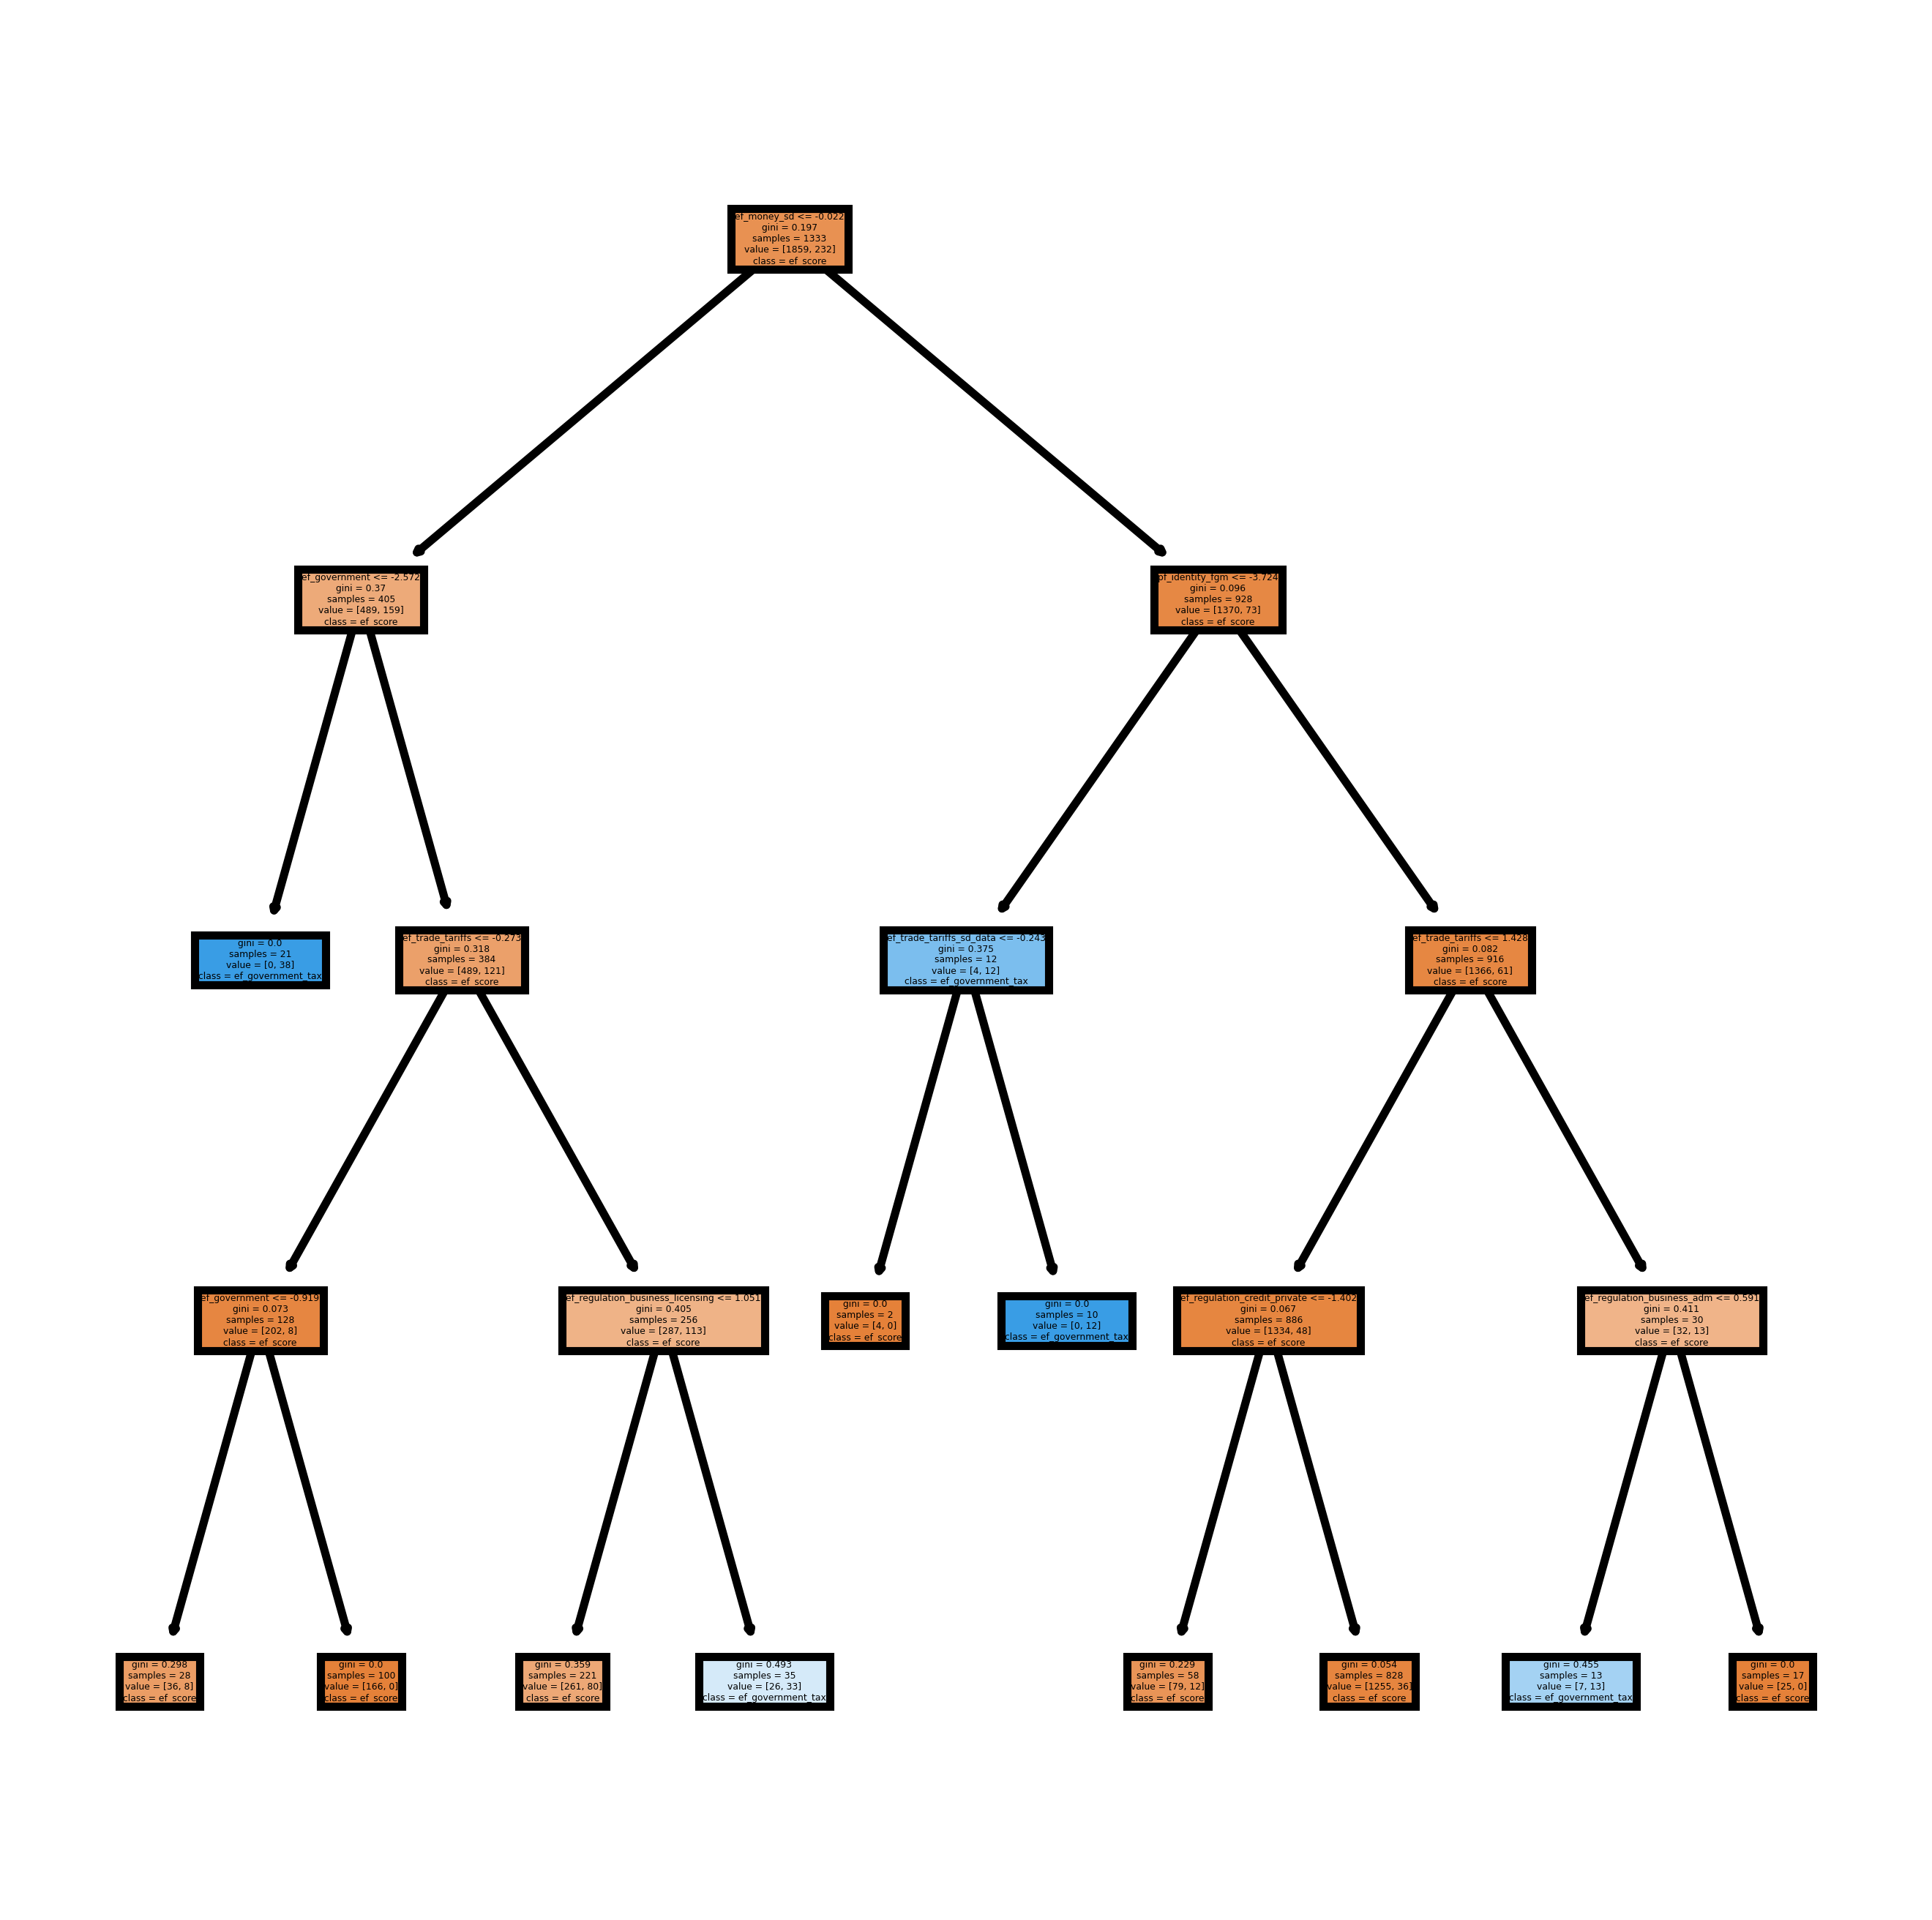

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Choose a tree from the random forest model
# Here we're choosing the first tree, but you can choose any tree
model = best_models_rf_temporal["ef_score"].estimators_[0]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
plot_tree(model,
          feature_names = X_temp_train.columns, 
          class_names=y_temp_train.columns,
          filled = True)
